In [34]:
from pyvirtualdisplay import Display
# 创建虚拟显示
display = Display(visible=0, size=(1024, 768))
display.start()

import os
import sys
# 你的其他代码
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4'
# using cloned code from https://github.com/facebookresearch/detr
# adding the dir to PYTHONPATH didn't work for some reason, some classes would import but others would not hence this nasty hack
project_root = 'wcl_files/aloha/act-plus-plus'

from detr.models.transformer import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer
from detr.models.transformer import Transformer as DETRTransformer
from detr.models.position_encoding import PositionEmbeddingSine, PositionEmbeddingLearned, NestedTensor

In [35]:
import torch
import numpy as np
import pickle
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from einops import rearrange
import copy

from utils import sample_battery_pose, sample_insertion_pose # robot functions
from visualize_episodes import save_videos
from pdb import set_trace
import matplotlib.pyplot as plt
import math
from typing import Optional, List
import h5py
from torch.utils.data import DataLoader
from pathlib import Path

import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torch import nn, Tensor

from sim_env import make_sim_env, NUT_POSE,BATTERY_POSE
from aim import Run

In [36]:
dry_run = True

In [37]:
args = {
    'num_epochs': 10000,
    'eval_interval_epochs': 500,
    'num_eval_rollouts': 100,
    'lr_backbone': 1e-5,
    'batch_size': 8,
    'trained_model_dir': '../experiments/aloha/sim_transfer_cube_scripted/second_workstream/',
    'task_name': 'sim_transfer_cube_scripted',
    'dataset_dir': 'data/sim_transfer_cube_scripted',
    'chunk_size': 100,  # chunk_size is --> num_queries <-- !!!!
    'd_model': 512,  # d_model
    'dim_feedforward': 3200,
    'lr': 1e-5,
    'kl_weight': 10,
    'state_dim': 14,
    'num_episodes': 40,
    'episode_len': 960,
    'camera_names': ['top'],
    'num_encoder_layers': 4,
    'num_decoder_layers': 7,
    'backbone': 'resnet18',
    'nhead': 8,
    'weight_decay': 1e-4,
    'dropout': 0.1,
    'position_embedding': 'sine',
    'normalize_before': False,
    'fps': 50,
    'latent_dim': 32,
}

if dry_run:
    args.update({
        'num_epochs': 2,
        'num_eval_rollouts': 2,
    })

In [38]:
run = Run(experiment="imitate_episodes", repo='dry_run' if dry_run else None)
run["hparams"] = args

# Data Loading

The next cell can be safely glossed over -- we look at the data the model is seeing below it.

In the next cell we are dealing with the intricacies of loading the data from `hdf` files which might not be all that relevant.

In [39]:
class EpisodicDataset(torch.utils.data.Dataset):
    def __init__(self, episode_ids):
        self.episode_ids = episode_ids
        self.norm_stats = get_norm_stats()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.episode_ids)

    def __getitem__(self, index):
        episode_id = self.episode_ids[index]
        dataset_path = os.path.join(args['dataset_dir'], f'episode_{episode_id}.hdf5')
        
        with h5py.File(dataset_path, 'r') as root:
            is_sim = root.attrs['sim']  # given what I'm planning, I will not need this flag
            is_sim = True
            episode_len = root['/action'].shape[0]  # 800
            
            start_ts = np.random.choice(episode_len)
            # get observation at start_ts only
            qpos = root['/observations/qpos'][start_ts]
            qvel = root['/observations/qvel'][start_ts]
            image_dict = dict()
            for cam_name in args['camera_names']:
                image_dict[cam_name] = root[f'/observations/images/{cam_name}'][start_ts]
            # get all actions after and including start_ts
            if is_sim:
                action = root['/action'][start_ts:]
                action_len = episode_len - start_ts
            else:
                # I have no clue why this branch of the if statement exists?!
                # maybe this is some artifact of how the data was captured...
                # if there is a delay in reading qpos... then winding actions by 0.02s might make sense
                # this is perplexing but I will leave this here in case it is useful in the future...
                action = root['/action'][max(0, start_ts - 1):] # hack, to make timesteps more aligned
                action_len = episode_len - max(0, start_ts - 1) # hack, to make timesteps more aligned

        self.is_sim = is_sim
        padded_action = np.zeros((episode_len, 14), dtype=np.float32)
        padded_action[:action_len] = action
        is_pad = np.zeros(episode_len)
        is_pad[action_len:] = 1

        all_cam_images = np.stack([image_dict[cam_name] for cam_name in args['camera_names']], axis=0)

        # construct observations
        image_data = torch.from_numpy(all_cam_images).float()
        qpos_data = torch.from_numpy(qpos).float()
        action_data = torch.from_numpy(padded_action).float()
        is_pad = torch.from_numpy(is_pad).bool()

        # channel last
        image_data = torch.einsum('k h w c -> k c h w', image_data)

        # normalize image and change dtype to float
        image_data /= 255.0
        image_data = self.normalize(image_data)
        action_data = (action_data - self.norm_stats["action_mean"]) / self.norm_stats["action_std"]
        qpos_data = (qpos_data - self.norm_stats["qpos_mean"]) / self.norm_stats["qpos_std"]

        return image_data[0], qpos_data, action_data, is_pad


def get_norm_stats():
    dataset_dir = Path(args['dataset_dir'])
    hdf5_files = list(dataset_dir.glob("*.hdf5"))
    all_qpos_data = []
    all_action_data = []
    for episode_path in hdf5_files:
        # dataset_path = os.path.join(dataset_dir, f'episode_{episode_idx}.hdf5')
        with h5py.File(episode_path, 'r') as root:
            qpos = root['/observations/qpos'][()]
            qvel = root['/observations/qvel'][()]
            action = root['/action'][()]
        all_qpos_data.append(torch.from_numpy(qpos))
        all_action_data.append(torch.from_numpy(action))
    all_qpos_data = torch.stack(all_qpos_data)
    all_action_data = torch.stack(all_action_data)
    all_action_data = all_action_data

    # normalize action data
    action_mean = all_action_data.mean(dim=[0, 1], keepdim=True)
    action_std = all_action_data.std(dim=[0, 1], keepdim=True)
    action_std = torch.clip(action_std, 1e-2, np.inf) # clipping

    # normalize qpos data
    qpos_mean = all_qpos_data.mean(dim=[0, 1], keepdim=True)
    qpos_std = all_qpos_data.std(dim=[0, 1], keepdim=True)
    qpos_std = torch.clip(qpos_std, 1e-2, np.inf) # clipping

    stats = {"action_mean": action_mean.numpy().squeeze(), "action_std": action_std.numpy().squeeze(),
             "qpos_mean": qpos_mean.numpy().squeeze(), "qpos_std": qpos_std.numpy().squeeze(),
             "example_qpos": qpos}

    return stats


def load_data(num_episodes, camera_names, batch_size_train, batch_size_val):
    print(f"\nData from: {args['dataset_dir']}\n")
    # obtain train test split
    train_ratio = 0.8
    shuffled_indices = np.random.permutation(num_episodes)
    train_indices = shuffled_indices[:int(train_ratio * num_episodes)]
    val_indices = shuffled_indices[int(train_ratio * num_episodes):]

    # construct dataset and dataloader
    train_dataset = EpisodicDataset(train_indices)
    val_dataset = EpisodicDataset(val_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=True, num_workers=1, prefetch_factor=1)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True, pin_memory=True, num_workers=1, prefetch_factor=1)

    return train_dataloader, val_dataloader


In [40]:
train_dataloader, val_dataloader = load_data(
    args['num_episodes'],
    args['camera_names'],
    batch_size_train=args['batch_size'],
    batch_size_val=args['batch_size']
)


Data from: data/sim_transfer_cube_scripted



In [41]:
images, qpos, actions, is_pad = next(iter(train_dataloader))

In [42]:
images.shape

torch.Size([8, 3, 480, 640])

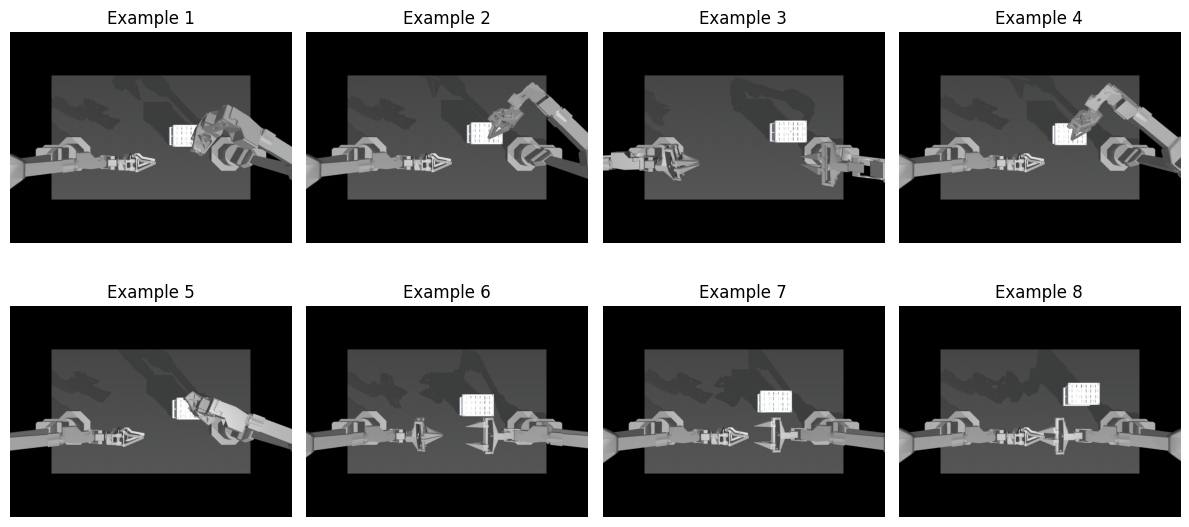

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
axes = axes.flatten()

for i in range(images.size(0)):
    image = images[i].squeeze(0)
    image *= np.array([0.229, 0.224, 0.225])[:, None, None]
    image += np.array([0.485, 0.456, 0.406])[:, None, None]
    image = image.permute(1, 2, 0).numpy().clip(0,1)
    axes[i].imshow(image)
    axes[i].axis('off')  # Remove the axis labels and ticks
    axes[i].set_title(f'Example {i+1}')

plt.tight_layout()
plt.show()

In [44]:
qpos.shape  # generalized position, normalized

torch.Size([8, 14])

In [45]:
qpos[0]

tensor([-0.0477,  0.5562, -0.6123, -0.0382, -0.4578,  0.3852,  0.4381, -0.0322,
         0.5468, -1.2355, -0.4608,  1.1234, -0.8571, -0.5401])

In [46]:
actions.shape  # controlling the arms is achieved via specifying the desired position
               # which is translated to actuator movement, normalized as well

torch.Size([8, 960, 14])

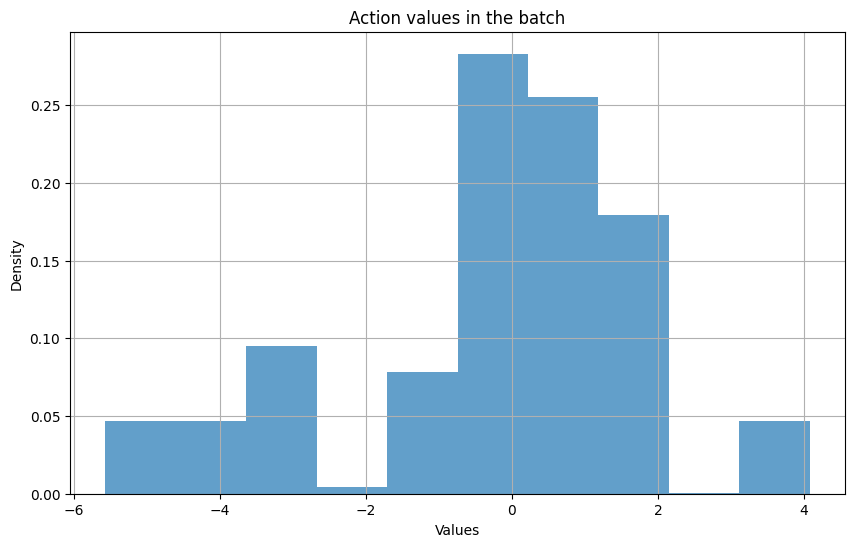

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(actions.reshape(1, -1).numpy()[0], bins=10, density=True, alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Action values in the batch')
plt.grid(True)
plt.show()

In [48]:
is_pad.shape

torch.Size([8, 960])

In [49]:
is_pad.sum(1)  # num padded entries, episode len vectors returned, but starting at sampled ts, rest padded to 0

tensor([565, 624,  49, 611, 247, 957, 911, 865])

In [50]:
actions.shape

torch.Size([8, 960, 14])

In [51]:
actions[0, -is_pad.sum(1)[0].item():]  # all entries are the same due to rescaling from dataset stats (x-x.mean) / x.std

tensor([[ 0.7405,  0.9254, -5.5705,  ..., -2.9147,  1.9028, -0.6059],
        [ 0.7405,  0.9254, -5.5705,  ..., -2.9147,  1.9028, -0.6059],
        [ 0.7405,  0.9254, -5.5705,  ..., -2.9147,  1.9028, -0.6059],
        ...,
        [ 0.7405,  0.9254, -5.5705,  ..., -2.9147,  1.9028, -0.6059],
        [ 0.7405,  0.9254, -5.5705,  ..., -2.9147,  1.9028, -0.6059],
        [ 0.7405,  0.9254, -5.5705,  ..., -2.9147,  1.9028, -0.6059]])

In [52]:
stats = train_dataloader.dataset.norm_stats
stats['action_mean']/stats['action_std']

array([-0.7404874 , -0.9253514 ,  5.570507  , -1.2423378 , -4.0798874 ,
        3.9837928 ,  3.3414948 , -1.4074208 , -1.1272405 ,  1.3477675 ,
        0.74338007,  2.9146597 , -1.9028052 ,  0.60594344], dtype=float32)

In [53]:
print('Actions to be taken till end of chunk_size/episode')
for i in range(is_pad.shape[0]):
    print(f'Example {i+1}: {is_pad[i].sum()}')

print('\nEmpty action slots (== 0)')
for i in range(is_pad.shape[0]):
    print(f'Example {i+1}: {(is_pad[i] == 0).sum()}')

Actions to be taken till end of chunk_size/episode
Example 1: 565
Example 2: 624
Example 3: 49
Example 4: 611
Example 5: 247
Example 6: 957
Example 7: 911
Example 8: 865

Empty action slots (== 0)
Example 1: 395
Example 2: 336
Example 3: 911
Example 4: 349
Example 5: 713
Example 6: 3
Example 7: 49
Example 8: 95


In [54]:
os.makedirs(args['trained_model_dir'], exist_ok=True)

stats_path = os.path.join(args['trained_model_dir'], 'dataset_stats.pkl')
with open(stats_path, 'wb') as f:
    pickle.dump(train_dataloader.dataset.norm_stats, f)

In [55]:
class Backbone(nn.Module):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name, position_embedding='sine'):
        super().__init__()
        backbone = getattr(torchvision.models, name)(pretrained=True)  # authors of ACT trained with frozen batchnorm, but not clear this should offer an advantage
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.num_channels = 512 if name in ('resnet18', 'resnet34') else 2048

        if position_embedding == 'sine':
            self.position_embedding = PositionEmbeddingSine(self.num_channels // 2, normalize=True)
        elif position_embedding == 'learned':
            self.position_embedding = PositionEmbeddingLearned(self.num_channels // 2)
        else:
            raise ValueError(f"not supported {position_embedding}")

    def forward(self, x):
        x = self.backbone(x)
        pos_embs = self.position_embedding(NestedTensor(x, torch.ones_like(x[0, [0]], dtype=torch.int8)))
        return NestedTensor(x, pos_embs)


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

![ACT Overview](ACT_overview.png)

In [56]:
class Transformer(DETRTransformer):
    def forward(self, src, pos_embed, query_embed):
        memory = self.encoder(src, src_key_padding_mask=None, pos=pos_embed)

        tgt = torch.zeros_like(query_embed)

        hs = self.decoder(tgt, memory, memory_key_padding_mask=None,
                          pos=pos_embed, query_pos=query_embed)
        return hs.transpose(1, 2)

The `forward` method of the `Transformer` is hard to understand at first sight. Why do we pass `queries` as `query_pos` which seems to suggest that they are positional encodings?

If we look at the multiheaded attention (a `nn.MultiheadAttention`) of the DETR `TransformerDecoderLayer`,  this becomes more clear:
```
tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                           key=self.with_pos_embed(memory, pos),
                           value=memory, attn_mask=memory_mask,
                           key_padding_mask=memory_key_padding_mask)[0]
```

The `self.with_pos_embed(...)` sums its arguments so in the first `TransformerDecoderLayer` of `TransformerDecoder` query is just `query_pos` (query embeddings).

In a sense query embeddings are positional embeddings -- the only information they carry is what value to be outputted for the `chunk_size` number of actions we are predicting.

In a standard transformer operating on text, queries would be obtained from summing positional encoding (`query_pos`) with the embedding of the word at current time step `t` and as the embedding travels up the transformer stack, we would hope that it would transform into a vector containing information that would lend itself well to predicitng the word idx for word at time step `t+1`.

The following excerpt from [Attention is all you need](https://arxiv.org/abs/1706.03762) describes how this is done:
```
In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and the memory keys and values come from the output of the encoder. This allows every
position in the decoder to attend over all positions in the input sequence. This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence models such as
[38, 2, 9].
```

`keys` and `values` come from the decoder, as we would expect.

Unless I am missing something, `queries` could be passed as `tgt` to decoder. That is what the image depicting ACT would suggest.

But it is much tougher to backpropagate gradient through the decoder layers all the way to the bottom. Here, using queries as position embeddings for a target of all zeroes means we are getting a residual connection at every decoder layer for free! Without modifying the original code. That is quite ingenious.

But if we look at DETR the image there, likewise, positions the queries where we would expect in
puts to the decoder, where shifted input would normally go!

Here is the architecture from Attention is all you need, for reference.
![attention is all you need](attention_is_all_you_need.png)

And here is a portrayal of DETR:
![DETR](DETR.png)

So while the images are very suggestive, they only partially capture how queries are used! Explained in [the DETR paper](https://arxiv.org/abs/2005.12872) and more explicitly via looking at what information gets passed where in code:

```
These input embeddings are learnt positional encodings that we refer to as object queries,
and similarly to the encoder, we add them to the input of each attention layer.
```

In [57]:
def sinusoid_encoding_table():
    n_position = args['chunk_size']+2
    d_hid = args['d_model']
    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table).unsqueeze(0).permute(1, 0, 2)

class DeviceAwareModule(nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

class cvaeEncoderInputCollator(DeviceAwareModule):
    '''
    Provides:
      * the class token embedding
      * positional encoding for a given `chunk_size` and `d_model`
      * projects actions and qpos to `d_model`
      '''
    def __init__(self):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, args['d_model']))
        self.action_proj = nn.Linear(14, args['d_model'])
        self.qpos_proj = nn.Linear(14, args['d_model'])
        self.pos_encoding = self.register_buffer('pos_encoding', sinusoid_encoding_table())
          
    def forward(self, actions, qpos, is_pad):
        bs = actions.shape[0]
        
        actions = self.action_proj(actions)       # (bs, chunk_size, d_model)
        qpos = self.qpos_proj(qpos).unsqueeze(1)  # (bs, 1, d_model)
        cls_token = self.cls_token.unsqueeze(1).repeat(bs, 1, 1) # (bs, 1, d_model)
        
        cls_qpos_actions = torch.cat([cls_token, qpos, actions], axis=1) # (bs, chunk_size+2, d_model)

        cls_qpos_is_pad = torch.zeros((bs, 2), device=self.device)
        cls_qpos_actions_is_pad = torch.cat([cls_qpos_is_pad, is_pad], axis=1)  # (bs, chunk_size+2)
        
        cls_qpos_actions = cls_qpos_actions.permute(1, 0, 2) # (chunk_size+2, bs, d_model)
        cls_qpos_actions_pos_encoding = self.pos_encoding
        return cls_qpos_actions, cls_qpos_actions_pos_encoding, cls_qpos_actions_is_pad


class cvaeEncoder(TransformerEncoder):
    def __init__(self):
        encoder_layer = TransformerEncoderLayer(args['d_model'], args['nhead'], args['dim_feedforward'],
                                        args['dropout'], "relu", args['normalize_before'])
        encoder_norm = nn.LayerNorm(d_model) if args['normalize_before'] else None
        super().__init__(encoder_layer, args['num_encoder_layers'], encoder_norm)
        
        self.cvae_encoder_input_collector = cvaeEncoderInputCollator()

    def forward(self, actions, qpos, is_pad):
        cls_qpos_actions, cls_qpos_actions_pos_encoding, cls_qpos_actions_is_pad = self.cvae_encoder_input_collector(actions, qpos, is_pad)
        encoder_output = super().forward(
            cls_qpos_actions,
            pos=cls_qpos_actions_pos_encoding,
            src_key_padding_mask=cls_qpos_actions_is_pad
        )
        style_variable_z = encoder_output[0]  # take output only for cls token
        
        return style_variable_z

In [58]:
class LatentDistributionSampler(DeviceAwareModule):
    def __init__(self):
        super().__init__()

        self.latent_var_proj =  nn.Linear(args['d_model'], args['latent_dim'] * 2)  # project latent variable to 2x latent_dim

    def forward(self, style_variable_z=None):
        if style_variable_z is not None:
            latent_distribution_parameters = self.latent_var_proj(style_variable_z)
            mu, logvar = latent_distribution_parameters.split(args['latent_dim'], dim=1)
            latent_sample = sample_from_normal_distribution(mu, logvar)
        else:
            latent_sample = torch.zeros([1, args['latent_dim']], dtype=torch.float32, device=self.device)
            mu, logvar = 0, 0
        return latent_sample, [mu, logvar]

In [59]:
class cvaeDecoderInputCollator(DeviceAwareModule):
    '''
    Provides:
      
      '''
    def __init__(self, vision_backbone):
        super().__init__()
        self.latent_out_proj = nn.Linear(args['latent_dim'], args['d_model'])  # project latent sample to d_model
        self.proprio_and_latent_pos = nn.Parameter(torch.randn(2, args['d_model']))
        self.robot_state_proj = nn.Linear(14, args['d_model'])  # project state/proprio features to d_model
        self.queries = nn.Parameter(torch.randn(args['chunk_size'], args['d_model']))
        
        self.vision_backbone = vision_backbone
        self.img_features_projector = nn.Conv2d(vision_backbone.num_channels, args['d_model'], kernel_size=1)
        
    def forward(self, latent_sample, images, qpos):
        batch_size = images.shape[0]
        
        latent_input = self.latent_out_proj(latent_sample)
        proprio_input = self.robot_state_proj(qpos)

        # image_feautres = (batch_size, d_model, feature_map_height, feature_map_width)
        # pos = like above, but 1 instead of batch_size
        image_features, pos = self.vision_backbone(images).decompose()
        
        #######
        # This is quite interesting -- feature maps with resnet 512 are 20 x 15
        # In the current formulation each "embedding" will have a collection of all pixels at a given location, say [0, 0]
        # across all feature maps. So we will get 20x15 = 300 embeddings with each containing one activation from each of the 512 channels.
        # Maybe this makes sense? It does make it simpler to ensure that we get embeddings of d_model size.
        # But one could argue that as convs operate on local patches, that it might be better to feed
        # each feature map into separate embedding. Though maybe the linear projections inside the transformer (calculating k,q,v)
        # make it not matter much/at all?
        # Might be worth trying it out at some point.
        
        image_features = image_features.flatten(2).permute(2,0,1)  # (width * height of feature map, bs, num channels == d_model)
        pos = pos.flatten(2).permute(2,0,1).repeat(1, batch_size, 1)
        
        queries = self.queries.unsqueeze(1).repeat(1, batch_size, 1)
        
        proprio_and_latent_pos = self.proprio_and_latent_pos.unsqueeze(1).repeat(1, image_features.shape[1], 1)
        pos = torch.cat([proprio_and_latent_pos, pos], axis=0)
        
        latent_and_proprio_input = torch.stack([latent_input, proprio_input], axis=1).permute(1,0,2)
        src = torch.cat([latent_and_proprio_input, image_features], axis=0)

        return src, pos, queries

In [60]:
class cvaeDecoder(Transformer):
    def __init__(self):
        
        arg_for_transformer = [
            'd_model', 'dropout', 'nhead', 'dim_feedforward', 'num_encoder_layers',
            'num_decoder_layers', 'normalize_before'
        ]
        super().__init__(**{k: args[k] for k in arg_for_transformer}) 

        vision_backbone = Backbone(args['backbone'])
        self.cvae_decoder_input_collector = cvaeDecoderInputCollator(vision_backbone)
        self.action_head = nn.Linear(args['d_model'], args['state_dim'])

    def forward(self, latent_sample, images, qpos):
        src, pos, queries = self.cvae_decoder_input_collector(latent_sample, images, qpos)
        hs = super().forward(src, pos, queries)  # hidden state from the last layer of the decoder stack
        a_hat = self.action_head(hs)
        return a_hat

In [61]:
def sample_from_normal_distribution(mu, logvar):
    std = logvar.div(2).exp()
    eps = std.new(std.size()).normal_()
    return mu + std * eps

In [62]:
class DETRVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cvaeEncoder = cvaeEncoder()
        self.latent_distribution_sampler = LatentDistributionSampler()
        self.cvaeDecoder = cvaeDecoder()

    def forward(self, qpos, images, actions=None, is_pad=None):
        """
        Dimensionalities:
          qpos: batch_size, state_dim
          image: batch_size, channel, height, width
          actions: batch_size, chunk_size, state_dim
        """
        if actions is not None:  # training
            style_variable_z = self.cvaeEncoder(actions, qpos, is_pad)    
            latent_sample, [mu, logvar] = self.latent_distribution_sampler(style_variable_z)
        else:
            latent_sample, [mu, logvar] = self.latent_distribution_sampler()
            
        a_hat = self.cvaeDecoder(latent_sample, images, qpos).squeeze(0)
        return a_hat, [mu, logvar]

In [63]:
class ACTPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DETRVAE().cuda()

    def __call__(self, qpos, image, actions=None, is_pad=None):
        if actions is not None: # training time
            actions = actions[:, :args['chunk_size']]  # experiment with different chunk_sizes
            is_pad = is_pad[:, :args['chunk_size']]

            a_hat, (mu, logvar) = self.model(qpos, image, actions, is_pad)
            total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
            l1 = F.l1_loss(actions, a_hat, reduction='none')
            mean_l1_masked_out_padding = (l1 * ~is_pad.unsqueeze(-1)).mean()
            loss = mean_l1_masked_out_padding + total_kld[0] * args['kl_weight']
            return loss
        else: # inference time
            a_hat, (_, _) = self.model(qpos, image) # no action, sample from prior
            return a_hat

In [64]:
policy = ACTPolicy()

print(f"KL Weight {args['kl_weight']}")

n_parameters = sum(p.numel() for p in policy.model.parameters() if p.requires_grad)
print("number of parameters: %.2fM" % (n_parameters/1e6))

/enter/envs/aloha/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/enter/envs/aloha/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KL Weight 10
number of parameters: 83.93M


In [65]:
normalize_fn = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def get_image(ts, camera_names):
    curr_images = []
    for cam_name in camera_names:
        curr_image = rearrange(ts.observation['images'][cam_name], 'h w c -> c h w')
        curr_images.append(curr_image)
    curr_image = np.stack(curr_images, axis=0)
    curr_image = torch.from_numpy(curr_image / 255.0).float().cuda().unsqueeze(0)
    curr_image = normalize_fn(curr_image)
    return curr_image[0]

def run_rollout_validation(ckpt_name='policy_best.ckpt', num_rollouts=20, query_frequency=20, save_video=False):
    policy = ACTPolicy()
    policy.load_state_dict(
        torch.load(os.path.join(args['trained_model_dir'], ckpt_name)
        )
    )
    policy.cuda()
    policy.eval()

    stats_path = os.path.join(args['trained_model_dir'], 'dataset_stats.pkl')
    with open(stats_path, 'rb') as f:
        stats = pickle.load(f)
    
    pre_process = lambda s_qpos: (s_qpos - stats['qpos_mean']) / stats['qpos_std']
    post_process = lambda a: a * stats['action_std'] + stats['action_mean']
    
    
    env = make_sim_env(args['task_name'])
    env_max_reward = env.task.max_reward

    max_timesteps = args['episode_len']

    episode_returns = []
    highest_rewards = []
    
    for rollout_id in range(num_rollouts):
        ### set task
        if 'sim_transfer_cube' in args['task_name']:
            BATTERY_POSE[0] = sample_battery_pose()
            #print("BATTERY_POSE",BATTERY_POSE[0])
            x_mid = BATTERY_POSE[0][0] - 8.3e-05
            y_mid = BATTERY_POSE[0][1] - 0.000118
            z_mid = BATTERY_POSE[0][2] + 0.159
            x_ul = BATTERY_POSE[0][0] - 0.070583
            y_ul = BATTERY_POSE[0][1] + 0.048882
            z_ul = BATTERY_POSE[0][2] + 0.159
            x_ur = BATTERY_POSE[0][0] + 0.072417
            y_ur = BATTERY_POSE[0][1] + 0.048882
            z_ur = BATTERY_POSE[0][2] + 0.159
            x_bl = BATTERY_POSE[0][0] - 0.070583
            y_bl = BATTERY_POSE[0][1] - 0.049118
            z_bl = BATTERY_POSE[0][2] + 0.159
            x_br = BATTERY_POSE[0][0] + 0.072417
            y_br = BATTERY_POSE[0][1] - 0.049118
            z_br = BATTERY_POSE[0][2] + 0.159
            nut_mid_position = np.array([x_mid, y_mid, z_mid])
            nut_ul_position = np.array([x_ul, y_ul, z_ul])
            nut_ur_position = np.array([x_ur, y_ur, z_ur])
            nut_bl_position = np.array([x_bl, y_bl, z_bl])
            nut_br_position = np.array([x_br, y_br, z_br])
            nut_quat = np.array([1, 0, 0, 0])
            nut_mid_pose = np.concatenate([nut_mid_position, nut_quat])
            nut_ul_pose = np.concatenate([nut_ul_position, nut_quat])
            nut_ur_pose = np.concatenate([nut_ur_position, nut_quat])
            nut_bl_pose = np.concatenate([nut_bl_position, nut_quat])
            nut_br_pose = np.concatenate([nut_br_position, nut_quat])
            nut_pose = np.concatenate([nut_mid_pose,nut_ul_pose,nut_ur_pose,nut_bl_pose,nut_br_pose])
            NUT_POSE[0] = nut_pose # used in sim reset
            

            
        elif 'sim_insertion' in args['task_name']:
            NUT_POSE[0] = np.concatenate(sample_insertion_pose()) # used in sim reset
    
        ts = env.reset()
    
        ### evaluation loop
        qpos_history = torch.zeros((1, max_timesteps, args['state_dim'])).cuda()
        image_list = [] # for visualization
        qpos_list = []
        target_qpos_list = []
        rewards = []
        with torch.inference_mode():
            for t in range(max_timesteps):
                ### process previous timestep to get qpos and image_list
                obs = ts.observation
                if 'images' in obs:
                    image_list.append(obs['images'])
                else:
                    image_list.append({'main': obs['image']})
                qpos = pre_process(obs['qpos'])
                qpos = torch.from_numpy(qpos).float().cuda().unsqueeze(0)
                qpos_history[:, t] = qpos
                curr_image = get_image(ts, args['camera_names'])
    
                ### query policy
                if t % query_frequency == 0:
                    all_actions = policy(qpos, curr_image)
                raw_action = all_actions[:, t % query_frequency]
    
                ### post-process actions
                raw_action = raw_action.squeeze(0).cpu().numpy()
                action = post_process(raw_action)
                target_qpos = action
    
                ### step the environment
                ts = env.step(target_qpos)
    
                ### for visualization
                qpos_list.append(qpos)
                target_qpos_list.append(target_qpos)
                rewards.append(ts.reward)
            plt.close()
    
            rewards = np.array(rewards)
            episode_return = np.sum(rewards[rewards!=None])
            episode_returns.append(episode_return)
            episode_highest_reward = np.max(rewards)
            highest_rewards.append(episode_highest_reward)
            print(f'Rollout {rollout_id}\n{episode_return=}, {episode_highest_reward=}, {env_max_reward=}, Success: {episode_highest_reward==env_max_reward}')
    
            if rollout_id == 0 and save_video:
                save_videos(image_list, 1/args['fps'], video_path=os.path.join(args['trained_model_dir'], 'rollout_0.mp4'))
    
            success_rate = np.mean(np.array(highest_rewards) == env_max_reward)
            avg_return = np.mean(episode_returns)
            summary_str = f'\nSuccess rate: {success_rate}\nAverage return: {avg_return}\n\n'
            for r in range(env_max_reward+1):
                more_or_equal_r = (np.array(highest_rewards) >= r).sum()
                more_or_equal_r_rate = more_or_equal_r / num_rollouts
                summary_str += f'Reward >= {r}: {more_or_equal_r}/{num_rollouts} = {more_or_equal_r_rate*100}%\n'
        
    return success_rate, avg_return

In [66]:
policy.cuda()

param_dicts = [
    {"params": [p for n, p in policy.model.named_parameters() if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in policy.model.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": args['lr_backbone'],
    },
]
optimizer = torch.optim.AdamW(param_dicts, lr=args['lr'], weight_decay=args['weight_decay'])

min_val_loss = np.inf
best_ckpt_info = None

for epoch in tqdm(range(args['num_epochs'])):
    print(f'\nEpoch {epoch}')
    # validation
    with torch.inference_mode():
        policy.eval()
        losses = []
        for image_data, qpos_data, action_data, is_pad in val_dataloader:
            image_data, qpos_data, action_data, is_pad = image_data.cuda(), qpos_data.cuda(), action_data.cuda(), is_pad.cuda()
            loss = policy(qpos_data, image_data, action_data, is_pad)
            losses.append(loss.cpu().numpy())

        epoch_val_loss = np.mean(losses)
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            best_ckpt_info = (epoch, min_val_loss, deepcopy(policy.state_dict()))
    print(f'Val loss:   {epoch_val_loss:.5f}')
    run.track(epoch_val_loss, name='loss', step=epoch, context={ "subset":"val" })

    # training
    policy.train()
    optimizer.zero_grad()
    for image_data, qpos_data, action_data, is_pad in train_dataloader:
        image_data, qpos_data, action_data, is_pad = image_data.cuda(), qpos_data.cuda(), action_data.cuda(), is_pad.cuda()
        loss = policy(qpos_data, image_data, action_data, is_pad)
    
        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    run.track(loss.item(), name='loss', step=epoch, context={ "subset":"train" })

    if epoch != 0 and (epoch % args['eval_interval_epochs'] == 0 or epoch == args['num_epochs']-1):
        ckpt_name = f'policy_epoch_{epoch}.ckpt'
        ckpt_path = os.path.join(args['trained_model_dir'], ckpt_name)
        torch.save(policy.state_dict(), ckpt_path)
        

        success_rate, avg_return = run_rollout_validation( f'policy_epoch_{epoch}.ckpt', num_rollouts=args['num_eval_rollouts'])
        print(f'{ckpt_name}: {success_rate=} {avg_return=}')
        
        run.track(success_rate, name='success_rate', step=epoch)
        run.track(avg_return, name='average_return', step=epoch)

ckpt_path = os.path.join(args['trained_model_dir'], f'policy_last.ckpt')
torch.save(policy.state_dict(), ckpt_path)

best_epoch, min_val_loss, best_state_dict = best_ckpt_info
ckpt_path = os.path.join(args['trained_model_dir'], f'policy_epoch_{best_epoch}.ckpt')
torch.save(best_state_dict, ckpt_path)
print(f'Training finished: val loss {min_val_loss:.6f} at epoch {best_epoch}')

  0%|          | 0/2 [00:00<?, ?it/s]


Epoch 0


  0%|          | 0/2 [00:00<?, ?it/s]


TypeError: 'NestedTensor' object is not subscriptable

In [ ]:
run.close()
display.stop()